# COMBINE L1 AND L2



In [1]:
import numpy as np
from mlp.layers import Layer

class TanhLayer(Layer):
    """Layer implementing an element-wise hyperbolic tangent transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = tanh(x)`.
        """
        return np.tanh(inputs)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (1. - outputs**2) * grads_wrt_outputs

    def __repr__(self):
        return 'TanhLayer'
    

class ReluLayer(Layer):
    """Layer implementing an element-wise rectified linear transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = max(0, x)`.
        """
        return np.maximum(inputs, 0.)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (outputs > 0) * grads_wrt_outputs

    def __repr__(self):
        return 'ReluLayer'

In [2]:
class L1Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L1 norm.
    """
    
    def __init__(self, coefficient):
        """Create a new L1 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L1 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return self.coefficient * abs(parameter).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * np.sign(parameter)
    
    def __repr__(self):
        return 'L1Penalty({0})'.format(self.coefficient)
        

class L2Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L2 norm.
    """

    def __init__(self, coefficient):
        """Create a new L2 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L2 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term..
            
            
            add a new item in the cost function function
        """
        return 0.5 * self.coefficient * (parameter**2).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
            
            partial derivative
        """
        return self.coefficient * parameter
    
    def __repr__(self):
        return 'L2Penalty({0})'.format(self.coefficient)
    

In [3]:
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

In [4]:
weights_penalties = [
    None,
    L1Penalty(1e-5),
    L1Penalty(1e-3),
    L2Penalty(1e-4),
    L2Penalty(1e-2)
]
run_info = OrderedDict()
models = OrderedDict()
for weights_penalty in weights_penalties:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    print('Regularisation: {0}'.format(weights_penalty))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init, weights_penalty)
    ])
    optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
    run_info[weights_penalty] = optimiser.train(num_epochs, stats_interval)
    models[weights_penalty] = model

Regularisation: None


Epoch 5: 0.72s to complete
  error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=9.67e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 10: 1.70s to complete
  error(train)=2.36e-02, acc(train)=9.94e-01, error(valid)=8.34e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 15: 0.99s to complete
  error(train)=8.49e-03, acc(train)=9.98e-01, error(valid)=8.34e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 1.11s to complete
  error(train)=3.42e-03, acc(train)=1.00e+00, error(valid)=9.58e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 0.79s to complete
  error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=9.48e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 0.86s to complete
  error(train)=9.06e-04, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 0.83s to complete
  error(train)=6.40e-04, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 4

Regularisation: L1Penalty(1e-05)


Epoch 5: 1.99s to complete
  error(train)=6.46e-02, acc(train)=9.82e-01, error(valid)=9.39e-02, acc(valid)=9.73e-01, params_penalty=2.89e-02
Epoch 10: 1.59s to complete
  error(train)=2.68e-02, acc(train)=9.93e-01, error(valid)=8.04e-02, acc(valid)=9.78e-01, params_penalty=3.03e-02
Epoch 15: 1.28s to complete
  error(train)=1.42e-02, acc(train)=9.97e-01, error(valid)=8.12e-02, acc(valid)=9.78e-01, params_penalty=3.06e-02
Epoch 20: 1.56s to complete
  error(train)=6.73e-03, acc(train)=9.99e-01, error(valid)=8.81e-02, acc(valid)=9.77e-01, params_penalty=2.99e-02
Epoch 25: 1.46s to complete
  error(train)=3.55e-03, acc(train)=1.00e+00, error(valid)=8.79e-02, acc(valid)=9.78e-01, params_penalty=2.85e-02
Epoch 30: 1.55s to complete
  error(train)=2.77e-03, acc(train)=1.00e+00, error(valid)=9.02e-02, acc(valid)=9.78e-01, params_penalty=2.69e-02
Epoch 35: 2.35s to complete
  error(train)=2.19e-03, acc(train)=1.00e+00, error(valid)=8.69e-02, acc(valid)=9.79e-01, params_penalty=2.56e-02
Epoch 4

Regularisation: L1Penalty(0.001)


Epoch 5: 1.37s to complete
  error(train)=2.53e-01, acc(train)=9.31e-01, error(valid)=2.40e-01, acc(valid)=9.35e-01, params_penalty=3.12e-01
Epoch 10: 1.46s to complete
  error(train)=2.20e-01, acc(train)=9.36e-01, error(valid)=2.13e-01, acc(valid)=9.38e-01, params_penalty=2.76e-01
Epoch 15: 1.40s to complete
  error(train)=2.27e-01, acc(train)=9.34e-01, error(valid)=2.15e-01, acc(valid)=9.38e-01, params_penalty=2.60e-01
Epoch 20: 1.34s to complete
  error(train)=2.74e-01, acc(train)=9.16e-01, error(valid)=2.56e-01, acc(valid)=9.20e-01, params_penalty=2.63e-01
Epoch 25: 1.36s to complete
  error(train)=2.28e-01, acc(train)=9.31e-01, error(valid)=2.26e-01, acc(valid)=9.30e-01, params_penalty=2.57e-01
Epoch 30: 1.37s to complete
  error(train)=2.16e-01, acc(train)=9.37e-01, error(valid)=2.07e-01, acc(valid)=9.40e-01, params_penalty=2.53e-01
Epoch 35: 1.38s to complete
  error(train)=2.08e-01, acc(train)=9.38e-01, error(valid)=1.99e-01, acc(valid)=9.41e-01, params_penalty=2.57e-01
Epoch 4

Regularisation: L2Penalty(0.0001)


Epoch 5: 0.90s to complete
  error(train)=6.49e-02, acc(train)=9.81e-01, error(valid)=9.48e-02, acc(valid)=9.72e-01, params_penalty=1.19e-02
Epoch 10: 0.91s to complete
  error(train)=2.65e-02, acc(train)=9.93e-01, error(valid)=8.14e-02, acc(valid)=9.78e-01, params_penalty=1.54e-02
Epoch 15: 0.93s to complete
  error(train)=1.41e-02, acc(train)=9.97e-01, error(valid)=8.20e-02, acc(valid)=9.78e-01, params_penalty=1.75e-02
Epoch 20: 0.90s to complete
  error(train)=6.66e-03, acc(train)=9.99e-01, error(valid)=8.53e-02, acc(valid)=9.78e-01, params_penalty=1.85e-02
Epoch 25: 0.90s to complete
  error(train)=3.56e-03, acc(train)=1.00e+00, error(valid)=8.34e-02, acc(valid)=9.79e-01, params_penalty=1.87e-02
Epoch 30: 0.88s to complete
  error(train)=2.80e-03, acc(train)=1.00e+00, error(valid)=8.27e-02, acc(valid)=9.79e-01, params_penalty=1.85e-02
Epoch 35: 0.90s to complete
  error(train)=2.53e-03, acc(train)=1.00e+00, error(valid)=8.15e-02, acc(valid)=9.80e-01, params_penalty=1.82e-02
Epoch 4

Regularisation: L2Penalty(0.01)


Epoch 5: 0.82s to complete
  error(train)=2.36e-01, acc(train)=9.41e-01, error(valid)=2.21e-01, acc(valid)=9.45e-01, params_penalty=2.90e-01
Epoch 10: 0.81s to complete
  error(train)=2.13e-01, acc(train)=9.45e-01, error(valid)=1.99e-01, acc(valid)=9.52e-01, params_penalty=2.95e-01
Epoch 15: 0.82s to complete
  error(train)=2.22e-01, acc(train)=9.44e-01, error(valid)=2.08e-01, acc(valid)=9.48e-01, params_penalty=2.96e-01
Epoch 20: 0.82s to complete
  error(train)=2.15e-01, acc(train)=9.46e-01, error(valid)=2.03e-01, acc(valid)=9.49e-01, params_penalty=2.98e-01
Epoch 25: 0.82s to complete
  error(train)=2.14e-01, acc(train)=9.47e-01, error(valid)=2.03e-01, acc(valid)=9.50e-01, params_penalty=2.99e-01
Epoch 30: 0.83s to complete
  error(train)=2.02e-01, acc(train)=9.51e-01, error(valid)=1.91e-01, acc(valid)=9.55e-01, params_penalty=2.99e-01
Epoch 35: 0.83s to complete
  error(train)=2.11e-01, acc(train)=9.47e-01, error(valid)=2.00e-01, acc(valid)=9.50e-01, params_penalty=2.97e-01
Epoch 4

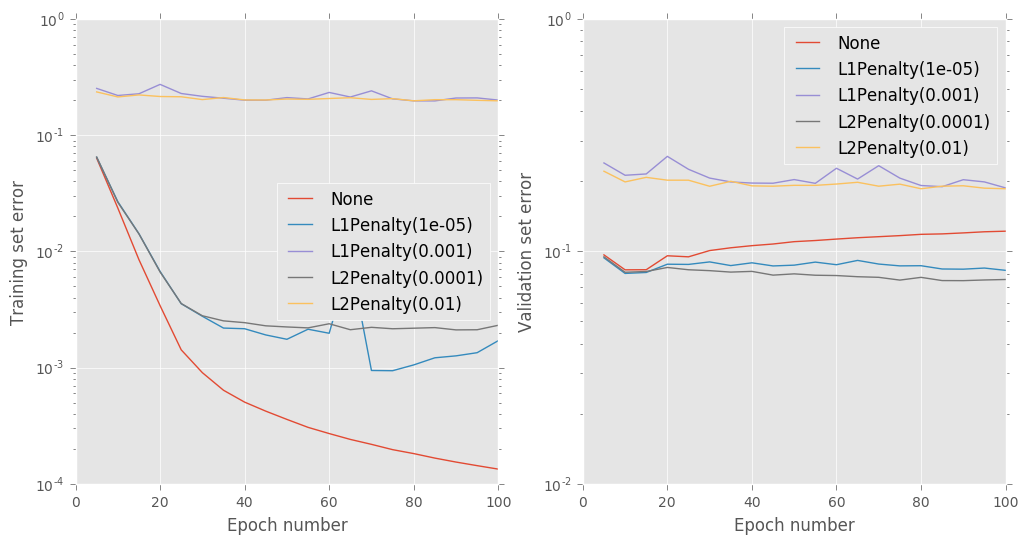

In [5]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
fig.savefig('l1or2.png')

In [7]:
class L12Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L1 norm.
    """
    
    def __init__(self, coefficient1, coefficient2):
        """Create a new L1 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient1 > 0 or coefficient2 > 0., 'One of Penalty coefficients must be positive in L1+L2.'
        self.coefficient1 = coefficient1
        self.coefficient2 = coefficient2
        
    def __call__(self, parameter):
        """Calculate L1 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return (self.coefficient1 * abs(parameter).sum())+(0.5 * self.coefficient2 * (parameter**2).sum())
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return (self.coefficient1 * np.sign(parameter))+(self.coefficient2 * parameter)
    
    def __repr__(self):
        return 'L12Penalty(L1:{0},L2:{1})'.format(self.coefficient1,self.coefficient2)
        

In [8]:
weights_penalties = [
    None,
    L12Penalty(1e-5,1e-4),
    L12Penalty(1e-5,0),
    L12Penalty(0,1e-4),
]
run_info = OrderedDict()
models = OrderedDict()
for weights_penalty in weights_penalties:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    print('Regularisation: {0}'.format(weights_penalty))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init, weights_penalty)
    ])
    optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
    run_info[weights_penalty] = optimiser.train(num_epochs, stats_interval)
    models[weights_penalty] = model

Regularisation: None


Epoch 5: 0.96s to complete
  error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=9.67e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 10: 0.76s to complete
  error(train)=2.36e-02, acc(train)=9.94e-01, error(valid)=8.34e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 15: 0.78s to complete
  error(train)=8.49e-03, acc(train)=9.98e-01, error(valid)=8.34e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 0.78s to complete
  error(train)=3.42e-03, acc(train)=1.00e+00, error(valid)=9.58e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 0.78s to complete
  error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=9.48e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 0.78s to complete
  error(train)=9.06e-04, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 0.78s to complete
  error(train)=6.40e-04, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 4

Regularisation: L12Penalty(L1:1e-05,L2:0.0001)


Epoch 5: 1.45s to complete
  error(train)=6.75e-02, acc(train)=9.81e-01, error(valid)=9.62e-02, acc(valid)=9.72e-01, params_penalty=3.89e-02
Epoch 10: 1.44s to complete
  error(train)=2.94e-02, acc(train)=9.92e-01, error(valid)=8.08e-02, acc(valid)=9.78e-01, params_penalty=4.21e-02
Epoch 15: 1.43s to complete
  error(train)=1.63e-02, acc(train)=9.96e-01, error(valid)=7.98e-02, acc(valid)=9.79e-01, params_penalty=4.32e-02
Epoch 20: 1.44s to complete
  error(train)=9.76e-03, acc(train)=9.98e-01, error(valid)=8.01e-02, acc(valid)=9.79e-01, params_penalty=4.28e-02
Epoch 25: 1.45s to complete
  error(train)=8.38e-03, acc(train)=9.99e-01, error(valid)=8.26e-02, acc(valid)=9.79e-01, params_penalty=4.15e-02
Epoch 30: 1.43s to complete
  error(train)=1.08e-02, acc(train)=9.98e-01, error(valid)=8.60e-02, acc(valid)=9.78e-01, params_penalty=4.00e-02
Epoch 35: 1.44s to complete
  error(train)=8.79e-03, acc(train)=9.99e-01, error(valid)=8.11e-02, acc(valid)=9.77e-01, params_penalty=3.88e-02
Epoch 4

Regularisation: L12Penalty(L1:1e-05,L2:0)


Epoch 5: 1.44s to complete
  error(train)=6.46e-02, acc(train)=9.82e-01, error(valid)=9.39e-02, acc(valid)=9.73e-01, params_penalty=2.89e-02
Epoch 10: 1.44s to complete
  error(train)=2.68e-02, acc(train)=9.93e-01, error(valid)=8.04e-02, acc(valid)=9.78e-01, params_penalty=3.03e-02
Epoch 15: 1.44s to complete
  error(train)=1.42e-02, acc(train)=9.97e-01, error(valid)=8.12e-02, acc(valid)=9.78e-01, params_penalty=3.06e-02
Epoch 20: 1.44s to complete
  error(train)=6.73e-03, acc(train)=9.99e-01, error(valid)=8.81e-02, acc(valid)=9.77e-01, params_penalty=2.99e-02
Epoch 25: 1.48s to complete
  error(train)=3.55e-03, acc(train)=1.00e+00, error(valid)=8.79e-02, acc(valid)=9.78e-01, params_penalty=2.85e-02
Epoch 30: 1.48s to complete
  error(train)=2.77e-03, acc(train)=1.00e+00, error(valid)=9.02e-02, acc(valid)=9.78e-01, params_penalty=2.69e-02
Epoch 35: 1.43s to complete
  error(train)=2.19e-03, acc(train)=1.00e+00, error(valid)=8.69e-02, acc(valid)=9.79e-01, params_penalty=2.56e-02
Epoch 4

Regularisation: L12Penalty(L1:0,L2:0.0001)


Epoch 5: 1.53s to complete
  error(train)=6.49e-02, acc(train)=9.81e-01, error(valid)=9.48e-02, acc(valid)=9.72e-01, params_penalty=1.19e-02
Epoch 10: 1.52s to complete
  error(train)=2.65e-02, acc(train)=9.93e-01, error(valid)=8.14e-02, acc(valid)=9.78e-01, params_penalty=1.54e-02
Epoch 15: 1.51s to complete
  error(train)=1.41e-02, acc(train)=9.97e-01, error(valid)=8.20e-02, acc(valid)=9.78e-01, params_penalty=1.75e-02
Epoch 20: 1.54s to complete
  error(train)=6.66e-03, acc(train)=9.99e-01, error(valid)=8.53e-02, acc(valid)=9.78e-01, params_penalty=1.85e-02
Epoch 25: 1.45s to complete
  error(train)=3.56e-03, acc(train)=1.00e+00, error(valid)=8.34e-02, acc(valid)=9.79e-01, params_penalty=1.87e-02
Epoch 30: 1.82s to complete
  error(train)=2.80e-03, acc(train)=1.00e+00, error(valid)=8.27e-02, acc(valid)=9.79e-01, params_penalty=1.85e-02
Epoch 35: 1.44s to complete
  error(train)=2.53e-03, acc(train)=1.00e+00, error(valid)=8.15e-02, acc(valid)=9.80e-01, params_penalty=1.82e-02
Epoch 4

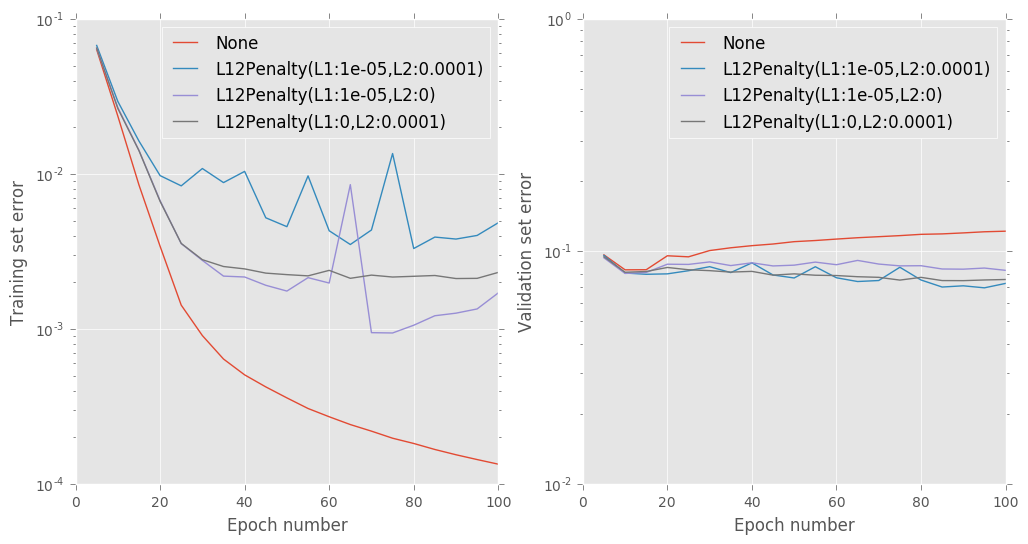

In [9]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
fig.savefig('better_than_none.png')

In [10]:
weights_penalties = [
    None,
    L12Penalty(1e-3,1e-4),
    L12Penalty(1e-5,1e-2),
    L12Penalty(1e-3,1e-2),
    L12Penalty(1e-3,0),
    L12Penalty(0,1e-2)
]
run_info = OrderedDict()
models = OrderedDict()
for weights_penalty in weights_penalties:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    print('Regularisation: {0}'.format(weights_penalty))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init, weights_penalty)
    ])
    optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
    run_info[weights_penalty] = optimiser.train(num_epochs, stats_interval)
    models[weights_penalty] = model

Regularisation: None


Epoch 5: 0.74s to complete
  error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=9.67e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 10: 0.79s to complete
  error(train)=2.36e-02, acc(train)=9.94e-01, error(valid)=8.34e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 15: 0.80s to complete
  error(train)=8.49e-03, acc(train)=9.98e-01, error(valid)=8.34e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 0.81s to complete
  error(train)=3.42e-03, acc(train)=1.00e+00, error(valid)=9.58e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 0.80s to complete
  error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=9.48e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 0.80s to complete
  error(train)=9.06e-04, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 0.82s to complete
  error(train)=6.40e-04, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 4

Regularisation: L12Penalty(L1:0.001,L2:0.0001)


Epoch 5: 1.44s to complete
  error(train)=2.55e-01, acc(train)=9.30e-01, error(valid)=2.42e-01, acc(valid)=9.35e-01, params_penalty=3.12e-01
Epoch 10: 1.44s to complete
  error(train)=2.25e-01, acc(train)=9.33e-01, error(valid)=2.17e-01, acc(valid)=9.36e-01, params_penalty=2.77e-01
Epoch 15: 1.45s to complete
  error(train)=2.22e-01, acc(train)=9.36e-01, error(valid)=2.08e-01, acc(valid)=9.37e-01, params_penalty=2.65e-01
Epoch 20: 1.45s to complete
  error(train)=2.68e-01, acc(train)=9.18e-01, error(valid)=2.49e-01, acc(valid)=9.23e-01, params_penalty=2.66e-01
Epoch 25: 2.27s to complete
  error(train)=2.27e-01, acc(train)=9.32e-01, error(valid)=2.21e-01, acc(valid)=9.32e-01, params_penalty=2.58e-01
Epoch 30: 1.51s to complete
  error(train)=1.94e-01, acc(train)=9.44e-01, error(valid)=1.90e-01, acc(valid)=9.46e-01, params_penalty=2.54e-01
Epoch 35: 1.54s to complete
  error(train)=2.05e-01, acc(train)=9.39e-01, error(valid)=1.99e-01, acc(valid)=9.42e-01, params_penalty=2.55e-01
Epoch 4

Regularisation: L12Penalty(L1:1e-05,L2:0.01)


Epoch 5: 1.33s to complete
  error(train)=2.39e-01, acc(train)=9.40e-01, error(valid)=2.24e-01, acc(valid)=9.44e-01, params_penalty=2.98e-01
Epoch 10: 1.35s to complete
  error(train)=2.16e-01, acc(train)=9.44e-01, error(valid)=2.02e-01, acc(valid)=9.51e-01, params_penalty=3.02e-01
Epoch 15: 1.34s to complete
  error(train)=2.24e-01, acc(train)=9.44e-01, error(valid)=2.09e-01, acc(valid)=9.48e-01, params_penalty=3.04e-01
Epoch 20: 1.35s to complete
  error(train)=2.18e-01, acc(train)=9.44e-01, error(valid)=2.05e-01, acc(valid)=9.48e-01, params_penalty=3.06e-01
Epoch 25: 1.33s to complete
  error(train)=2.16e-01, acc(train)=9.46e-01, error(valid)=2.04e-01, acc(valid)=9.49e-01, params_penalty=3.06e-01
Epoch 30: 1.36s to complete
  error(train)=2.05e-01, acc(train)=9.51e-01, error(valid)=1.93e-01, acc(valid)=9.55e-01, params_penalty=3.06e-01
Epoch 35: 1.36s to complete
  error(train)=2.14e-01, acc(train)=9.46e-01, error(valid)=2.03e-01, acc(valid)=9.50e-01, params_penalty=3.04e-01
Epoch 4

Regularisation: L12Penalty(L1:0.001,L2:0.01)


Epoch 5: 1.43s to complete
  error(train)=3.65e-01, acc(train)=9.07e-01, error(valid)=3.41e-01, acc(valid)=9.16e-01, params_penalty=4.39e-01
Epoch 10: 1.43s to complete
  error(train)=3.44e-01, acc(train)=9.09e-01, error(valid)=3.17e-01, acc(valid)=9.16e-01, params_penalty=4.29e-01
Epoch 15: 1.44s to complete
  error(train)=3.51e-01, acc(train)=9.06e-01, error(valid)=3.24e-01, acc(valid)=9.14e-01, params_penalty=4.27e-01
Epoch 20: 1.46s to complete
  error(train)=3.46e-01, acc(train)=9.05e-01, error(valid)=3.19e-01, acc(valid)=9.15e-01, params_penalty=4.24e-01
Epoch 25: 1.53s to complete
  error(train)=3.52e-01, acc(train)=9.02e-01, error(valid)=3.27e-01, acc(valid)=9.11e-01, params_penalty=4.16e-01
Epoch 30: 1.55s to complete
  error(train)=3.39e-01, acc(train)=9.12e-01, error(valid)=3.14e-01, acc(valid)=9.22e-01, params_penalty=4.15e-01
Epoch 35: 1.54s to complete
  error(train)=3.60e-01, acc(train)=8.96e-01, error(valid)=3.35e-01, acc(valid)=9.09e-01, params_penalty=4.11e-01
Epoch 4

Regularisation: L12Penalty(L1:0.001,L2:0)


Epoch 5: 1.46s to complete
  error(train)=2.53e-01, acc(train)=9.31e-01, error(valid)=2.40e-01, acc(valid)=9.35e-01, params_penalty=3.12e-01
Epoch 10: 1.48s to complete
  error(train)=2.20e-01, acc(train)=9.36e-01, error(valid)=2.13e-01, acc(valid)=9.38e-01, params_penalty=2.76e-01
Epoch 15: 1.47s to complete
  error(train)=2.27e-01, acc(train)=9.34e-01, error(valid)=2.15e-01, acc(valid)=9.38e-01, params_penalty=2.60e-01
Epoch 20: 1.47s to complete
  error(train)=2.74e-01, acc(train)=9.16e-01, error(valid)=2.56e-01, acc(valid)=9.20e-01, params_penalty=2.63e-01
Epoch 25: 1.47s to complete
  error(train)=2.28e-01, acc(train)=9.31e-01, error(valid)=2.26e-01, acc(valid)=9.30e-01, params_penalty=2.57e-01
Epoch 30: 1.48s to complete
  error(train)=2.16e-01, acc(train)=9.37e-01, error(valid)=2.07e-01, acc(valid)=9.40e-01, params_penalty=2.53e-01
Epoch 35: 1.46s to complete
  error(train)=2.08e-01, acc(train)=9.38e-01, error(valid)=1.99e-01, acc(valid)=9.41e-01, params_penalty=2.57e-01
Epoch 4

Regularisation: L12Penalty(L1:0,L2:0.01)


Epoch 5: 1.30s to complete
  error(train)=2.36e-01, acc(train)=9.41e-01, error(valid)=2.21e-01, acc(valid)=9.45e-01, params_penalty=2.90e-01
Epoch 10: 1.29s to complete
  error(train)=2.13e-01, acc(train)=9.45e-01, error(valid)=1.99e-01, acc(valid)=9.52e-01, params_penalty=2.95e-01
Epoch 15: 2.53s to complete
  error(train)=2.22e-01, acc(train)=9.44e-01, error(valid)=2.08e-01, acc(valid)=9.48e-01, params_penalty=2.96e-01
Epoch 20: 1.28s to complete
  error(train)=2.15e-01, acc(train)=9.46e-01, error(valid)=2.03e-01, acc(valid)=9.49e-01, params_penalty=2.98e-01
Epoch 25: 1.27s to complete
  error(train)=2.14e-01, acc(train)=9.47e-01, error(valid)=2.03e-01, acc(valid)=9.50e-01, params_penalty=2.99e-01
Epoch 30: 1.29s to complete
  error(train)=2.02e-01, acc(train)=9.51e-01, error(valid)=1.91e-01, acc(valid)=9.55e-01, params_penalty=2.99e-01
Epoch 35: 1.28s to complete
  error(train)=2.11e-01, acc(train)=9.47e-01, error(valid)=2.00e-01, acc(valid)=9.50e-01, params_penalty=2.97e-01
Epoch 4

In [ ]:
------------------------------------------------------

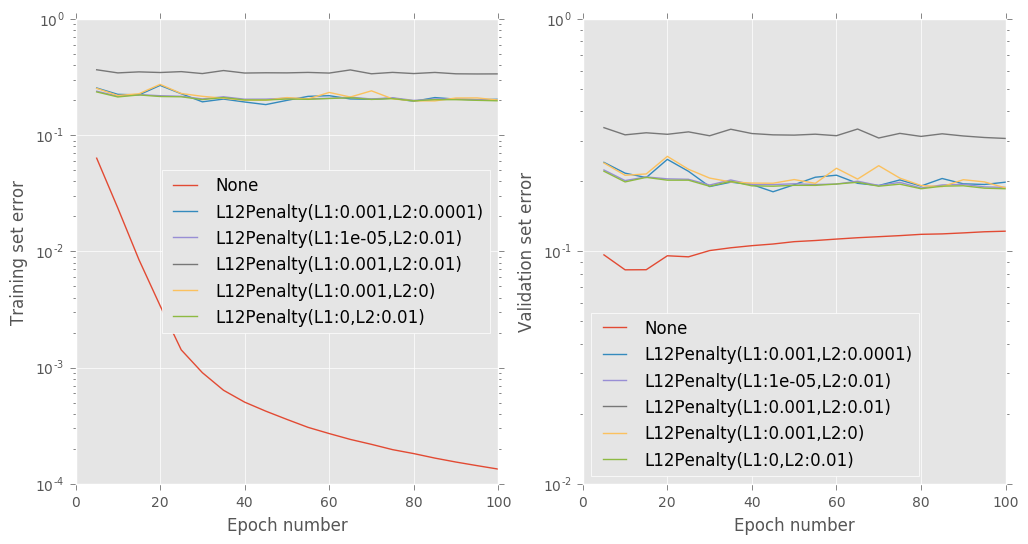

In [11]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
fig.savefig('worse_than_none.png')

In [10]:
weights_penalties = [
    None,
    L12Penalty(1e-3,1e-4),
    L12Penalty(1e-5,1e-2),
    L12Penalty(1e-3,1e-2),
    L12Penalty(1e-3,1e-4),
]
run_info = OrderedDict()
models = OrderedDict()
for weights_penalty in weights_penalties:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    print('Regularisation: {0}'.format(weights_penalty))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init, weights_penalty)
    ])
    optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
    run_info[weights_penalty] = optimiser.train(num_epochs, stats_interval)
    models[weights_penalty] = model

Regularisation: None


Epoch 5: 0.74s to complete
  error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=9.67e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 10: 0.79s to complete
  error(train)=2.36e-02, acc(train)=9.94e-01, error(valid)=8.34e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 15: 0.80s to complete
  error(train)=8.49e-03, acc(train)=9.98e-01, error(valid)=8.34e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 0.81s to complete
  error(train)=3.42e-03, acc(train)=1.00e+00, error(valid)=9.58e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 0.80s to complete
  error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=9.48e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 0.80s to complete
  error(train)=9.06e-04, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 0.82s to complete
  error(train)=6.40e-04, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 4

Regularisation: L12Penalty(L1:0.001,L2:0.0001)


Epoch 5: 1.44s to complete
  error(train)=2.55e-01, acc(train)=9.30e-01, error(valid)=2.42e-01, acc(valid)=9.35e-01, params_penalty=3.12e-01
Epoch 10: 1.44s to complete
  error(train)=2.25e-01, acc(train)=9.33e-01, error(valid)=2.17e-01, acc(valid)=9.36e-01, params_penalty=2.77e-01
Epoch 15: 1.45s to complete
  error(train)=2.22e-01, acc(train)=9.36e-01, error(valid)=2.08e-01, acc(valid)=9.37e-01, params_penalty=2.65e-01
Epoch 20: 1.45s to complete
  error(train)=2.68e-01, acc(train)=9.18e-01, error(valid)=2.49e-01, acc(valid)=9.23e-01, params_penalty=2.66e-01
Epoch 25: 2.27s to complete
  error(train)=2.27e-01, acc(train)=9.32e-01, error(valid)=2.21e-01, acc(valid)=9.32e-01, params_penalty=2.58e-01
Epoch 30: 1.51s to complete
  error(train)=1.94e-01, acc(train)=9.44e-01, error(valid)=1.90e-01, acc(valid)=9.46e-01, params_penalty=2.54e-01
Epoch 35: 1.54s to complete
  error(train)=2.05e-01, acc(train)=9.39e-01, error(valid)=1.99e-01, acc(valid)=9.42e-01, params_penalty=2.55e-01
Epoch 4

Regularisation: L12Penalty(L1:1e-05,L2:0.01)


Epoch 5: 1.33s to complete
  error(train)=2.39e-01, acc(train)=9.40e-01, error(valid)=2.24e-01, acc(valid)=9.44e-01, params_penalty=2.98e-01
Epoch 10: 1.35s to complete
  error(train)=2.16e-01, acc(train)=9.44e-01, error(valid)=2.02e-01, acc(valid)=9.51e-01, params_penalty=3.02e-01
Epoch 15: 1.34s to complete
  error(train)=2.24e-01, acc(train)=9.44e-01, error(valid)=2.09e-01, acc(valid)=9.48e-01, params_penalty=3.04e-01
Epoch 20: 1.35s to complete
  error(train)=2.18e-01, acc(train)=9.44e-01, error(valid)=2.05e-01, acc(valid)=9.48e-01, params_penalty=3.06e-01
Epoch 25: 1.33s to complete
  error(train)=2.16e-01, acc(train)=9.46e-01, error(valid)=2.04e-01, acc(valid)=9.49e-01, params_penalty=3.06e-01
Epoch 30: 1.36s to complete
  error(train)=2.05e-01, acc(train)=9.51e-01, error(valid)=1.93e-01, acc(valid)=9.55e-01, params_penalty=3.06e-01
Epoch 35: 1.36s to complete
  error(train)=2.14e-01, acc(train)=9.46e-01, error(valid)=2.03e-01, acc(valid)=9.50e-01, params_penalty=3.04e-01
Epoch 4

Regularisation: L12Penalty(L1:0.001,L2:0.01)


Epoch 5: 1.43s to complete
  error(train)=3.65e-01, acc(train)=9.07e-01, error(valid)=3.41e-01, acc(valid)=9.16e-01, params_penalty=4.39e-01
Epoch 10: 1.43s to complete
  error(train)=3.44e-01, acc(train)=9.09e-01, error(valid)=3.17e-01, acc(valid)=9.16e-01, params_penalty=4.29e-01
Epoch 15: 1.44s to complete
  error(train)=3.51e-01, acc(train)=9.06e-01, error(valid)=3.24e-01, acc(valid)=9.14e-01, params_penalty=4.27e-01
Epoch 20: 1.46s to complete
  error(train)=3.46e-01, acc(train)=9.05e-01, error(valid)=3.19e-01, acc(valid)=9.15e-01, params_penalty=4.24e-01
Epoch 25: 1.53s to complete
  error(train)=3.52e-01, acc(train)=9.02e-01, error(valid)=3.27e-01, acc(valid)=9.11e-01, params_penalty=4.16e-01
Epoch 30: 1.55s to complete
  error(train)=3.39e-01, acc(train)=9.12e-01, error(valid)=3.14e-01, acc(valid)=9.22e-01, params_penalty=4.15e-01
Epoch 35: 1.54s to complete
  error(train)=3.60e-01, acc(train)=8.96e-01, error(valid)=3.35e-01, acc(valid)=9.09e-01, params_penalty=4.11e-01
Epoch 4

Regularisation: L12Penalty(L1:0.001,L2:0)


Epoch 5: 1.46s to complete
  error(train)=2.53e-01, acc(train)=9.31e-01, error(valid)=2.40e-01, acc(valid)=9.35e-01, params_penalty=3.12e-01
Epoch 10: 1.48s to complete
  error(train)=2.20e-01, acc(train)=9.36e-01, error(valid)=2.13e-01, acc(valid)=9.38e-01, params_penalty=2.76e-01
Epoch 15: 1.47s to complete
  error(train)=2.27e-01, acc(train)=9.34e-01, error(valid)=2.15e-01, acc(valid)=9.38e-01, params_penalty=2.60e-01
Epoch 20: 1.47s to complete
  error(train)=2.74e-01, acc(train)=9.16e-01, error(valid)=2.56e-01, acc(valid)=9.20e-01, params_penalty=2.63e-01
Epoch 25: 1.47s to complete
  error(train)=2.28e-01, acc(train)=9.31e-01, error(valid)=2.26e-01, acc(valid)=9.30e-01, params_penalty=2.57e-01
Epoch 30: 1.48s to complete
  error(train)=2.16e-01, acc(train)=9.37e-01, error(valid)=2.07e-01, acc(valid)=9.40e-01, params_penalty=2.53e-01
Epoch 35: 1.46s to complete
  error(train)=2.08e-01, acc(train)=9.38e-01, error(valid)=1.99e-01, acc(valid)=9.41e-01, params_penalty=2.57e-01
Epoch 4

Regularisation: L12Penalty(L1:0,L2:0.01)


Epoch 5: 1.30s to complete
  error(train)=2.36e-01, acc(train)=9.41e-01, error(valid)=2.21e-01, acc(valid)=9.45e-01, params_penalty=2.90e-01
Epoch 10: 1.29s to complete
  error(train)=2.13e-01, acc(train)=9.45e-01, error(valid)=1.99e-01, acc(valid)=9.52e-01, params_penalty=2.95e-01
Epoch 15: 2.53s to complete
  error(train)=2.22e-01, acc(train)=9.44e-01, error(valid)=2.08e-01, acc(valid)=9.48e-01, params_penalty=2.96e-01
Epoch 20: 1.28s to complete
  error(train)=2.15e-01, acc(train)=9.46e-01, error(valid)=2.03e-01, acc(valid)=9.49e-01, params_penalty=2.98e-01
Epoch 25: 1.27s to complete
  error(train)=2.14e-01, acc(train)=9.47e-01, error(valid)=2.03e-01, acc(valid)=9.50e-01, params_penalty=2.99e-01
Epoch 30: 1.29s to complete
  error(train)=2.02e-01, acc(train)=9.51e-01, error(valid)=1.91e-01, acc(valid)=9.55e-01, params_penalty=2.99e-01
Epoch 35: 1.28s to complete
  error(train)=2.11e-01, acc(train)=9.47e-01, error(valid)=2.00e-01, acc(valid)=9.50e-01, params_penalty=2.97e-01
Epoch 4

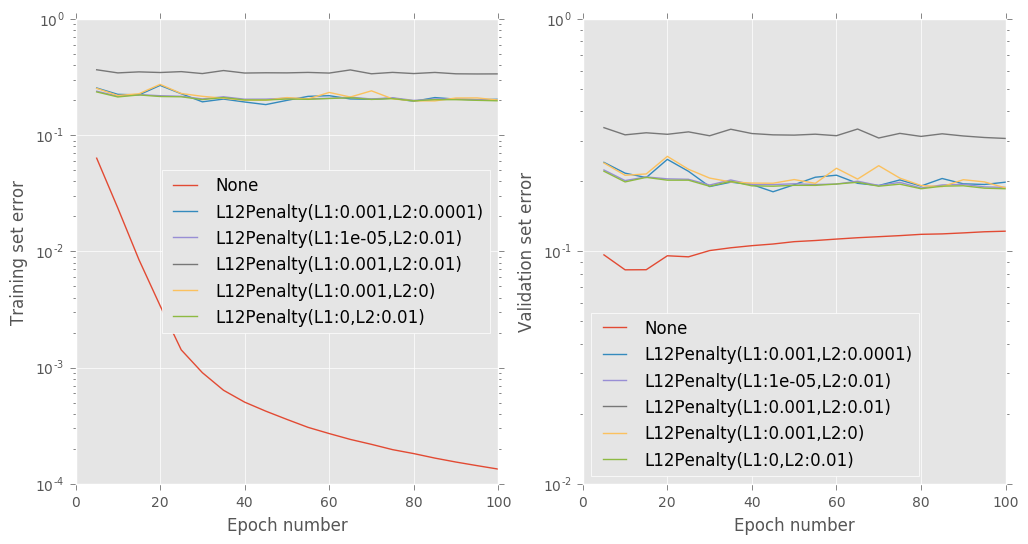

In [11]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
fig.savefig('worse_than_none.png')